# Encoding the world and an attempt to retrieve from it

In this assignment we'll be trying to simulate the process of encoding and retrieval by creating a toy world and encode items/objects as it appears in the world and also try to retrieve it.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [6]:
#Global Parameters
N_WORLD_FEATURES = 5;
N_ITEMS = 10;
ENCODING_TIME = 500;
TEST_TIME = 20;

In [54]:
def drawFromADist(p):
    if(np.sum(p)==0):
        p = 0.05*np.ones(len(p))
    p=p/np.sum(p) #Normalization
    c=np.cumsum(p)
    idx=np.where((np.random.random(1)-c)<0)
    sample=np.min(idx)
#     out = np.zeros(len(p))
#     out[sample] = 1
   
    return sample

In [55]:
'''Utility function to encode context of the world'''
def encoding_items(world_m, world_var, delta, schedule, small_mean, large_mean, gaussian=False):
    
    m=0
    for time in range(ENCODING_TIME):
        
        #Sampling from a bimodal gaussian distribution only if delta is a variable
        if(gaussian==True):
            delta=sample_gaussian(small_mean,large_mean)
            
        
        world_m= beta_param*world_m+ delta
        world=np.random.normal(world_m, world_var)
        
        
        if(m<N_ITEMS):
            if(time==schedule[m,0]):
                encoding[m,0:5]=world
                encoding[m,5]=m
                m+=1
                
    return encoding

In [39]:
'''Utility function for retrieval'''
def retrieval(world_m, world_var, delta, schedule, small_mean, large_mean, gaussian=False):
    m=0
    out=np.zeros(TEST_TIME)
    
    encoding=encoding_items(world_m, world_var, delta, schedule, small_mean, large_mean, gaussian)
   
    time=ENCODING_TIME
    
    while(time<(ENCODING_TIME+TEST_TIME)):
        if(gaussian==True):
            delta=sample_gaussian(small_mean, large_mean)

        world_m= beta_param*world_m+ delta
        world=np.random.normal(world_m, world_var)
        soa=np.zeros(N_ITEMS)
        
        temp=np.zeros(N_WORLD_FEATURES+1)
        
        for m in range(N_ITEMS):
            temp[0:5]=world
            temp[5]=m
            soa[m]=np.dot(encoding[m], temp.T) #Finding association strength via outer_product
            
        soa=soa/np.linalg.norm(soa) #Normalization
        
#         out[time-ENCODING_TIME] = np.where(drawFromADist(soa)>0)[0]
        out[time-ENCODING_TIME] = drawFromADist(soa)
        time += 1;   
    
    
    success=len(np.unique(out))
        
    return success
        

In [56]:
'''Making random presentation schedule'''
schedule =np.column_stack((np.sort(np.round(np.random.random(N_ITEMS)*ENCODING_TIME)),np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
schedule,schedule_load


(array([[  1.,   0.],
        [122.,   1.],
        [244.,   2.],
        [268.,   3.],
        [326.,   4.],
        [338.,   5.],
        [367.,   6.],
        [390.,   7.],
        [446.,   8.],
        [467.,   9.]]),
 17.24137931034483)

array([495.20954172, 255.90915327, 368.4711005 , 431.87556714,
        42.95269823])

In [57]:
world_m = np.array([1 ,2 ,1, 2, 3])          
world_var = 1
'''Delta parameter indicates by how much the world is changing or drifting'''
delta = 0.09  

'''Used to represent the weight(or importance) we're giving to the previous context of 
    the world'''
beta_param = 0.9 
m = 0

In [71]:
1,2,3,4,5,104,203,302,401,500




(1, 2, 3, 4, 5, 104, 203, 302, 401, 500)

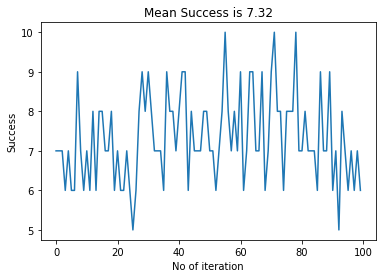

Scheduling Load 17.24137931034483


In [58]:
success=list()
for i in range(100):
    success.append(retrieval(world_m, world_var, delta ,schedule, 0, 5))
    
success=np.array(success)

plt.plot(np.arange(100),success[:])
plt.ylabel('Success')
plt.xlabel('No of iteration')
plt.title('Mean Success is '+str(np.mean(success[:])))

plt.show()
print("Scheduling Load", schedule_load)

## Gaussian world

Now we'll be assuming that the drift parameter is not constant and is being sampled from a bimodal gaussian distribution with 2 means: a smaller one and a larger one and we'll be exploring how the nature of a changing world affects memory encoding and recall in the following section. We'll also try to find the optimal schedule which shows a decent performance in both retrieval and minimizing scheduling load/encoding load.

In [59]:
small_mean=0
large_mean=5

In [60]:
'''Returns a sample from bimodal gaussian with a smaller mean or a larger mean'''
def sample_gaussian(small_mean, large_mean):
#     small_mean=0
#     large_mean=1
    variance=1
    gaussian_means=[small_mean, large_mean]
    
    
    return np.random.normal(gaussian_means[np.random.randint(0,2)], variance)

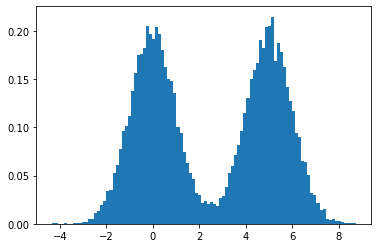

In [61]:
#Plotting the Bimodal gaussian world
num_samples=10000

var=1
y=np.concatenate((np.random.normal(small_mean, var, num_samples ), np.random.normal(large_mean, var, num_samples)))

plt.hist(y, density=True, bins=100)
plt.show()

In [62]:
retrieval(world_m, world_var, delta, schedule, small_mean, large_mean, gaussian=True)

9

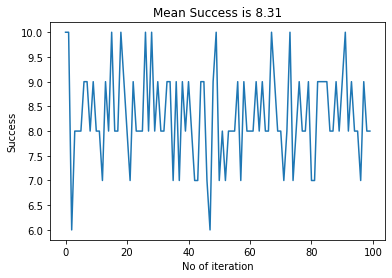

Scheduling Load 17.24137931034483


In [63]:
success=list()
for i in range(100):
    success.append(retrieval(world_m, world_var, delta, schedule, small_mean, large_mean,  gaussian=True))
    
success=np.array(success)

plt.plot(np.arange(100),success[:])
plt.ylabel('Success')
plt.xlabel('No of iteration')
plt.title('Mean Success is '+str(np.mean(success[:])))

plt.show()
print("Scheduling Load", schedule_load)

## Optimal schedule

- Optimality in this context is akin to **1)minimum scheduling load with 2)retrivals >7**. For the first objective, i.e. minimizing scheduling load, we can look at the formula to come up with an idea. The formula is :

$$ Load = \frac{ENCODING\:TIME}{median(diff\:b/w \:2\:consequtive\:elements)} $$

- From the formula above, we can reckon that the Encoding time is constant and **to decrease the Load we need to increase the denominator or the median of differences** in the schedule to have an effect of a lower scheduling load.

- As we've 10 items sorted in the schedule, our consequtive differences array will have 9 elements. Intuitively we can allow a **jump(or a big time difference) b/w the appearances of 5th and 6th item**. Or, diff(6th item)-5th item will be our median. 

- As we've considered difference b/w 6th and 5th item to be our median, which translates to 5th item in our differences array, **we've to make sure that 4 elements to the left of median are lesser than or equal to median and elements on the right side are greater or equal to median.**

- To achieve a big jump b/w 5th and 6th element we can **cram or shove the timings in the first half to be consequtive or the timings in the last half of the array to be consequtive**, we'll be going with the second option and the rationale behind it is, **if we encode a list of items just before the ENCODING PERIOD ends, it's easier to "recall" when the TEST PERIOD starts following the ENCODING PERIOD, possibly leading to more retrievals**. 

- At this point our scheduling list looks like: [_,_,_,_,_,496,497,498,499,500] and we need to figure out rest of the elements.Let 5th element be $ a_5 $, so $495-a_5 $ = our median, which should be lesser than or equal to max diff b/w consequtive 5 elements in the first half.

- If we want to keep more elements we need to make the gap b/w the elements smaller, and we also need to maintain the constraint of keep it atleast as much as diff b/w 6th and 5th element. So, if the first element is 1, and the the gap is same for all the 5 elments, $ diff=\frac{a_5 - 1}{4}=496-a_5 $

$$ a_5=397, diff=99 $$

- So, the entire schedule becomes [1,100,199,298,397,496,497,498,499,500]



In [64]:
schedule=np.column_stack(([1,100,199,298,397,496,497,498,499,500],np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
# encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
schedule,schedule_load


(array([[  1,   0],
        [100,   1],
        [199,   2],
        [298,   3],
        [397,   4],
        [496,   5],
        [497,   6],
        [498,   7],
        [499,   8],
        [500,   9]]),
 5.05050505050505)

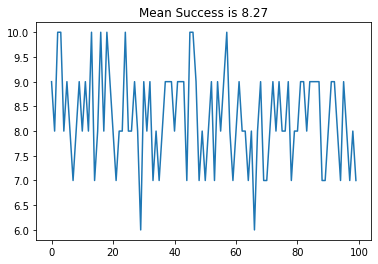

Scheduling Load 5.05050505050505


In [65]:
success=list()
for i in range(100):
    success.append(retrieval(world_m, world_var, delta, schedule, 0, 5, gaussian=True))
    
success=np.array(success)

plt.plot(np.arange(100),success[:])
plt.title('Mean Success is '+str(np.mean(success[:])))

plt.show()

print("Scheduling Load", schedule_load)

As we can observe from the above diagram, with optimal schedule we've managed to achieve a good retrieval(or mean success) rate and we've also managed to minimize the scheduling load.

## Generating model of the world

In the following segment, we don't know the model of the world(or the means of bimodal distributions), but we'll be trying to create a generative model of the world based on the datapoints we're getting exposed to. To replicate similar behavior in code, we'll be using EM technique to approximate the mean of the distributions based on a large sample of data, sampled from the mixture of 2 Gaussians.

In [66]:
#Sampling datapoints from a bimodal gaussian distribution
sample=[]

for i in range(20000):
    sample.append((sample_gaussian(small_mean, large_mean),0))
    


In [67]:
gm= GaussianMixture(n_components=2, random_state=0).fit(sample)


In [68]:
small_mean=gm.means_[0][0]
large_mean=gm.means_[1][0]
small_mean, large_mean=min(small_mean,large_mean), max(small_mean, large_mean)

small_mean, large_mean

(-0.008229196547331855, 4.97119027143361)

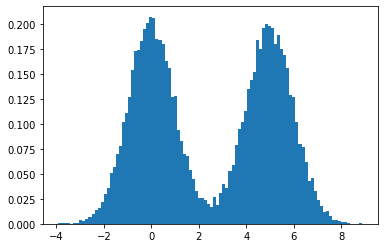

In [69]:
#Plotting the Approximation of Bimodal gaussian world
num_samples=10000

var=1
y=np.concatenate((np.random.normal(small_mean, var, num_samples ), np.random.normal(large_mean, var, num_samples)))

plt.hist(y, density=True, bins=100)
plt.show()

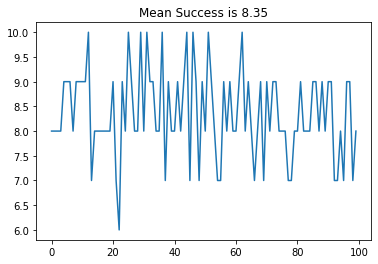

Scheduling Load: 5.05050505050505


In [70]:
success=list()
for i in range(100):
    success.append(retrieval(world_m, world_var, delta, schedule, small_mean, large_mean, gaussian=True))
    
success=np.array(success)

plt.plot(np.arange(100),success[:])
plt.title('Mean Success is '+str(np.mean(success[:])))

plt.show()
print("Scheduling Load:",schedule_load)

A quick look at the above plot will tell us that even with an approximate knowledge of the evolving world, retrieval rate is decent on using the optimal schedule we've built so far.

## References

1. CS786A Lecture Slides
2. https://memory.psych.upenn.edu/files/pubs/HowaKaha02.pdf

## Acknowledgements

I'm thankful to my fellow-mates Manjyot and Sharanya to participate in brainstorming sessions which are invaluable while solving difficult assignments. :)